In [1]:
reset -fs

# Exploratory Data Analysis (EDA):
plot feature importances of full model

In [4]:
import re 
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict, Counter
from sklearn.datasets import fetch_covtype # dataset
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, classification_report, precision_recall_fscore_support
import xgboost as xgb
from xgboost import XGBClassifier
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
%matplotlib inline

import re
from sklearn.datasets import fetch_covtype # dataset
from sklearn.model_selection import train_test_split # split dataset into training/test sets
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
import pandas as pd

/Users/adamszabunio/anaconda/envs/nlp/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


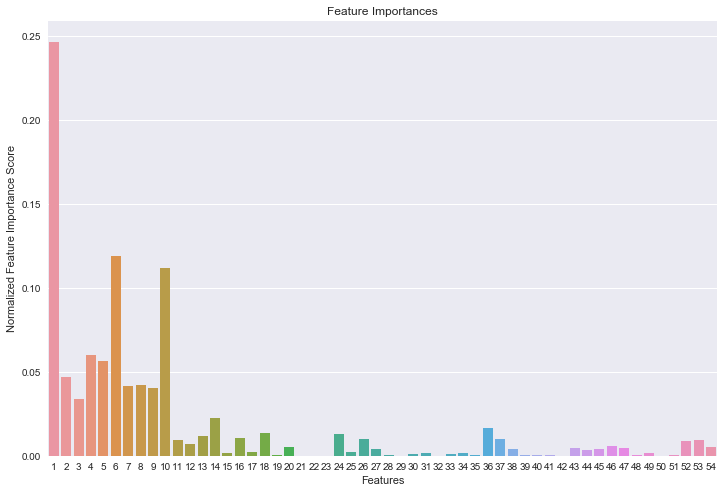

In [13]:
import seaborn as sns
rcParams['figure.figsize'] = 12, 8
sns.barplot([i[1]+1 for i in srt_index], [i[0] for i in srt_index])
plt.title("Feature Importances");
plt.xlabel("Features")
plt.ylabel("Normalized Feature Importance Score");


In [2]:
# download the dataset from:
# "http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
cover_type = fetch_covtype() 

In [3]:
cover_type.DESCR

'Forest covertype dataset.\n\nA classic dataset for classification benchmarks, featuring categorical and\nreal-valued features.\n\nThe dataset page is available from UCI Machine Learning Repository\n\n    http://archive.ics.uci.edu/ml/datasets/Covertype\n\nCourtesy of Jock A. Blackard and Colorado State University.\n'

# Preprocessing:

Explore the frequency counts. Are there any terms that should be removed from your feature set? Why or why not?
Does removing stop-wording or hapaxes help?

# Vectorizing:

How did vectorization effect the modeling step?
Did tf-idf have an effect? Why or why not?

In [4]:
cover_type.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

In [5]:
# from the Forest_Cover_Type.ipynb data exploration we discovered there are 7 distinct cover_types
# set these covertypes as our target, y 
y = cover_type.target

In [6]:
cover_type.data.shape

(581012, 54)

Elevation: Elevation in meters
Aspect: Aspect in degrees azimuth
Slope: Slope in degrees
Horizontal Distance To Hydrology: Horz Dist to nearest surface water features 
Vertical Distance To Hydrology: Vert Dist to nearest surface water features
Horizontal Distance To Roadways: Horz Dist to nearest roadway
Hillshade 9am (0 to 255 index): Hillshade index at 9am, summer solstice
Hillshade Noon (0 to 255 index): Hillshade index at noon, summer solstice
Hillshade 3pm (0 to 255 index): Hillshade index at 3pm, summer solstice
Horizontal Distance To Fire Points: Horz Dist to nearest wildfire ignition points
Wilderness Area (4 binary columns, 0 = absence or 1 = presence): Wilderness area designation
Soil Type (40 binary columns, 0 = absence or 1 = presence): Soil Type designation
Cover Type (7 types, integers 1 to 7): Forest Cover Type designation

In [7]:
# Our data contains 54 features. Explored in depth within the Forest_Cover_Type.ipynb
# set this 581012 x 54 matrix as our feature matrix, X
X = cover_type.data

In [23]:
soil_types = { 
    "2702": "Cathedral family - Rock outcrop complex, extremely stony.",
    "2703": "Vanet - Ratake families complex, very stony.", 
    "2704": "Haploborolis - Rock outcrop complex, rubbly.",
    "2705": "Ratake family - Rock outcrop complex, rubbly.",
    "2706": "Vanet family - Rock outcrop complex complex, rubbly.",
    "2717": "Vanet - Wetmore families - Rock outcrop complex, stony.",
    "3501": "Gothic family.",
    "3502": "Supervisor - Limber families complex.",
    "4201": "Troutville family, very stony.",
    "4703": "Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    "4704": "Bullwark - Catamount families - Rock land complex, rubbly.",
    "4744": "Legault family - Rock land complex, stony.",
    "4758": "Catamount family - Rock land - Bullwark family complex, rubbly.",
    "5101": "Pachic Argiborolis - Aquolis complex.",
    "5151": "unspecified in the USFS Soil and ELU Survey.",
    "6101": "Cryaquolis - Cryoborolis complex.",
    "6102": "Gateview family - Cryaquolis complex.",
    "6731": "Rogert family, very stony.",
    "7101": "Typic Cryaquolis - Borohemists complex.",
    "7102": "Typic Cryaquepts - Typic Cryaquolls complex.",
    "7103": "Typic Cryaquolls - Leighcan family, till substratum complex.",
    "7201": "Leighcan family, till substratum, extremely bouldery.",
    "7202": "Leighcan family, till substratum - Typic Cryaquolls complex.",
    "7700": "Leighcan family, extremely stony.",
    "7701": "Leighcan family, warm, extremely stony.",
    "7702": "Granile - Catamount families complex, very stony.",
    "7709": "Leighcan family, warm - Rock outcrop complex, extremely stony.",
    "7710": "Leighcan family - Rock outcrop complex, extremely stony.",
    "7745": "Como - Legault families complex, extremely stony.",
    "7746": "Como family - Rock land - Legault family complex, extremely stony.",
    "7755": "Leighcan - Catamount families complex, extremely stony.",
    "7756": "Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    "7757": "Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    "7790": "Cryorthents - Rock land complex, extremely stony.",
    "8703": "Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    "8707": "Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    "8708": "Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    "8771": "Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    "8772": "Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    "8776": "Moran family - Cryorthents - Rock land complex, extremely stony."}

In [26]:
# First digit:  climatic zone   
first_digit = { "1": "lower montane dry",
                "2": "lower montane",          
                "3": "montane dry",            
                "4": "montane",                
                "5": "montane dry and montane",
                "6": "montane and subalpine",
                "7": "subalpine",  
                "8": "alpine" 
              }  

# Second digit:  geologic zones
second_digit = {"1": "alluvium",
                "2": "glacial",
                "3": "shale",
                "4": "sandstone",
                "5": "mixed sedimentary",
                "6": "unspecified in the USFS ELU Survey",
                "7": "igneous and metamorphic",
                "8": "volcanic"
               }

# The third and fourth ELU digits are unique to the mapping unit and 
# have no special meaning to the climatic or geologic zones.

In [24]:
for k, v in soil_types.items():
    soil_types[k] = re.sub(" -", ".", v) # re.sub(" - ", " ", v)

In [25]:
soil_types

{'2702': 'Cathedral family. Rock outcrop complex, extremely stony.',
 '2703': 'Vanet. Ratake families complex, very stony.',
 '2704': 'Haploborolis. Rock outcrop complex, rubbly.',
 '2705': 'Ratake family. Rock outcrop complex, rubbly.',
 '2706': 'Vanet family. Rock outcrop complex complex, rubbly.',
 '2717': 'Vanet. Wetmore families. Rock outcrop complex, stony.',
 '3501': 'Gothic family.',
 '3502': 'Supervisor. Limber families complex.',
 '4201': 'Troutville family, very stony.',
 '4703': 'Bullwark. Catamount families. Rock outcrop complex, rubbly.',
 '4704': 'Bullwark. Catamount families. Rock land complex, rubbly.',
 '4744': 'Legault family. Rock land complex, stony.',
 '4758': 'Catamount family. Rock land. Bullwark family complex, rubbly.',
 '5101': 'Pachic Argiborolis. Aquolis complex.',
 '5151': 'unspecified in the USFS Soil and ELU Survey.',
 '6101': 'Cryaquolis. Cryoborolis complex.',
 '6102': 'Gateview family. Cryaquolis complex.',
 '6731': 'Rogert family, very stony.',
 '710

In [27]:
soil_types_extend = defaultdict(str, soil_types)

for k in soil_types_extend.keys():
    climatic = " climatic zone " + first_digit.get(k[0])
    geologic = " geologic zone " + second_digit.get(k[1])
    soil_types_extend[k] += climatic + geologic

In [28]:
soil_types_extend

defaultdict(str,
            {'2702': 'Cathedral family. Rock outcrop complex, extremely stony. climatic zone lower montane geologic zoneigneous and metamorphic',
             '2703': 'Vanet. Ratake families complex, very stony. climatic zone lower montane geologic zoneigneous and metamorphic',
             '2704': 'Haploborolis. Rock outcrop complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
             '2705': 'Ratake family. Rock outcrop complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
             '2706': 'Vanet family. Rock outcrop complex complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
             '2717': 'Vanet. Wetmore families. Rock outcrop complex, stony. climatic zone lower montane geologic zoneigneous and metamorphic',
             '3501': 'Gothic family. climatic zone montane dry geologic zonemixed sedimentary',
             '3502': 'Supervisor. Limber families complex

In [37]:
# The wilderness areas are
wilderness_areas =   {'Wilderness_Area1': "Rawah Wilderness Area", 
                      'Wilderness_Area2': "Neota Wilderness Area",
                      'Wilderness_Area3': "Comanche Peak Wilderness Area",
                      'Wilderness_Area4': "Cache la Poudre Wilderness Area"}

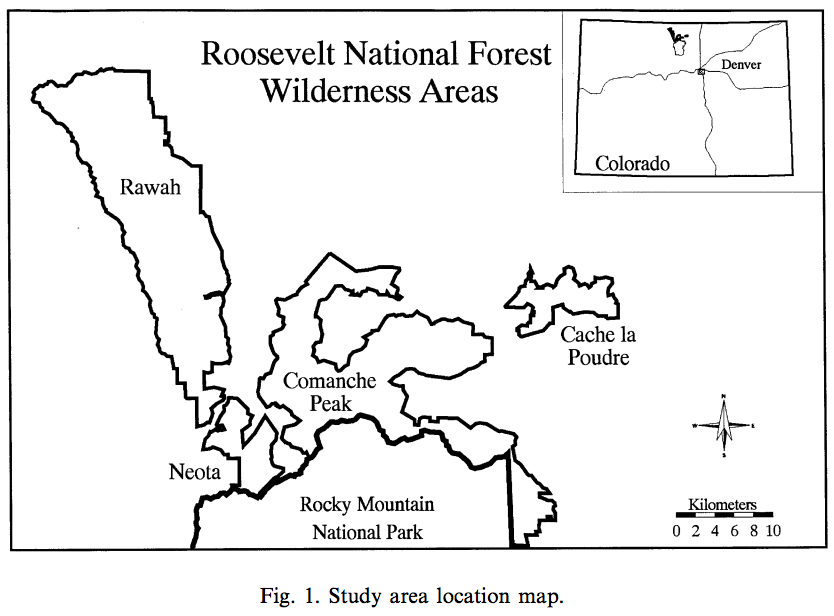

In [4]:
Image("AOI.png")

In [29]:
soil_cols = list(soil_types_extend.keys())

In [30]:
cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'] + soil_cols
cols

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 '2702',
 '2703',
 '2704',
 '2705',
 '2706',
 '2717',
 '3501',
 '3502',
 '4201',
 '4703',
 '4704',
 '4744',
 '4758',
 '5101',
 '5151',
 '6101',
 '6102',
 '6731',
 '7101',
 '7102',
 '7103',
 '7201',
 '7202',
 '7700',
 '7701',
 '7702',
 '7709',
 '7710',
 '7745',
 '7746',
 '7755',
 '7756',
 '7757',
 '7790',
 '8703',
 '8707',
 '8708',
 '8771',
 '8772',
 '8776']

In [ ]:
pd.set_option("display.max_columns", len(cols))
test = pd.DataFrame(X, columns=cols, dtype=int).head()

In [31]:
test

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,2702,2703,2704,2705,2706,2717,3501,3502,4201,4703,4704,4744,4758,5101,5151,6101,6102,6731,7101,7102,7103,7201,7202,7700,7701,7702,7709,7710,7745,7746,7755,7756,7757,7790,8703,8707,8708,8771,8772,8776
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
print(" ".join(str(v) for v in test.loc[0] if v > 0))


2596 51 3 258 510 221 232 148 6279 1 1


In [32]:
testing = pd.DataFrame(test, dtype=str)
testing

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,2702,2703,2704,2705,2706,2717,3501,3502,4201,4703,4704,4744,4758,5101,5151,6101,6102,6731,7101,7102,7103,7201,7202,7700,7701,7702,7709,7710,7745,7746,7755,7756,7757,7790,8703,8707,8708,8771,8772,8776
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [54]:
# testing[soil_cols] = testing[soil_cols].replace("0", "", inplace=True)

/Users/adamszabunio/anaconda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def whitespace(zero):
    return 

In [57]:
testing.apply(str.replace("0", ""))

TypeError: replace() takes at least 2 arguments (1 given)

In [42]:
test2 = pd.DataFrame(test, dtype='str')
test2

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,2702,2703,2704,2705,2706,2717,3501,3502,4201,4703,4704,4744,4758,5101,5151,6101,6102,6731,7101,7102,7103,7201,7202,7700,7701,7702,7709,7710,7745,7746,7755,7756,7757,7790,8703,8707,8708,8771,8772,8776
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
feats = {"Elevation": "Elevation in meters ",
         "Aspect": "Aspect in degrees azimuth ",
         "Slope": "Slope in degrees ",
         "Horizontal Distance To Hydrology": "Horizontal Distance to nearest surface water features ",
         "Vertical_Distance_To_Hydrology": "Vertical Distance to nearest surface water features ",
         "Horizontal_Distance_To_Roadways": "Horizontal Distance to nearest roadway ",
         "Hillshade_9am": "Hillshade index at 9am, summer solstice ",
         "Hillshade_Noon": "Hillshade index at noon, summer solstice ",
         "Hillshade_3pm": "Hillshade index at 3pm, summer solstice ",
         "Horizontal_Distance_To_Fire_Points": "Horizontal Distance to nearest wildfire ignition points "
        }

In [43]:
test2.Elevation = feats["Elevation"] + test2.Elevation

In [44]:
test2

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,2702,2703,2704,2705,2706,2717,3501,3502,4201,4703,4704,4744,4758,5101,5151,6101,6102,6731,7101,7102,7103,7201,7202,7700,7701,7702,7709,7710,7745,7746,7755,7756,7757,7790,8703,8707,8708,8771,8772,8776
0,Elevation in meters 2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Elevation in meters 2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Elevation in meters 2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Elevation in meters 2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Elevation in meters 2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
soil_cols_values = list(soil_types_extend.values())

In [45]:
cols_w_vals = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'] + soil_cols_values
cols_w_vals

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Cathedral family. Rock outcrop complex, extremely stony. climatic zone lower montane geologic zoneigneous and metamorphic',
 'Vanet. Ratake families complex, very stony. climatic zone lower montane geologic zoneigneous and metamorphic',
 'Haploborolis. Rock outcrop complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
 'Ratake family. Rock outcrop complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
 'Vanet family. Rock outcrop complex complex, rubbly. climatic zone lower montane geologic zoneigneous and metamorphic',
 'Vanet. Wetmore families. Rock outcrop complex, stony. climatic zone lower montane geologic

In [47]:
test_vals = pd.DataFrame(X,columns=cols_w_vals).head()

In [48]:
test_vals[soil_cols_values].idxmax(axis=1) 

0    Como. Legault families complex, extremely ston...
1    Como. Legault families complex, extremely ston...
2    Legault family. Rock land complex, stony. clim...
3    Como family. Rock land. Legault family complex...
4    Como. Legault families complex, extremely ston...
dtype: object

In [9]:
# since our dataset is rather large, and we will be doing cross validation on our training set,
# we set the train_size parameter to be 90% and set aside %10 to test on
# due to large class imbalances in our target matrix, we
# set the stratify parameter=y. this makes a split so that the proportion of classes in the 
# test and train sets will be similar
X_train, X_test, y_train, y_test=\
                            train_test_split(X, y, train_size=.90, random_state=42, stratify=y)

/Users/adamszabunio/anaconda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
print(X_train.shape, X_test.shape)

(522910, 54) (58102, 54)


In [11]:
pd.Da

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
Image("AOI.png")

In [3]:
srt_index[0]

[0.24660715000309424, 0]

In [2]:
srt_index = [[0.24660715000309424, 0],
 [0.11880706413405626, 5],
 [0.11152332641382312, 9],
 [0.059908103854401686, 3],
 [0.05645230632134722, 4],
 [0.047170463008234624, 1],
 [0.041989991641566075, 7],
 [0.041393662003483399, 6],
 [0.040573691144154225, 8],
 [0.03374382486116325, 2],
 [0.022282472125462558, 13],
 [0.016397530318239713, 35],
 [0.013449267507324187, 17],
 [0.013250193937924695, 23],
 [0.011661033568579889, 12],
 [0.010540464318108169, 15],
 [0.010170187339738216, 36],
 [0.010121195893610394, 25],
 [0.0096949731577236822, 10],
 [0.0091872477096017341, 52],
 [0.0089744993140728011, 51],
 [0.006788750888043503, 11],
 [0.0055391919733450423, 45],
 [0.0054293017962487528, 53],
 [0.0053588437574285715, 19],
 [0.0049212520631274469, 42],
 [0.0047951413589761554, 46],
 [0.0041894587820109786, 26],
 [0.0040481499729057464, 37],
 [0.0040246374942260969, 44],
 [0.0031794358396381893, 43],
 [0.0022974648204542028, 16],
 [0.0020622543592601233, 24],
 [0.0019328281663092354, 48],
 [0.0018229078709950189, 33],
 [0.0016653287563386, 30],
 [0.0016444338163877404, 14],
 [0.00087358872976643306, 32],
 [0.00086695437039335083, 29],
 [0.00073455187202405708, 34],
 [0.00064538854267874981, 40],
 [0.00063984919724873628, 50],
 [0.00061868426918536409, 18],
 [0.00056286891815842874, 47],
 [0.00034229307678299877, 39],
 [0.00031240009684501021, 27],
 [0.0002641289528231494, 38],
 [0.00016403733873380822, 41],
 [0.00012673478571201076, 49],
 [0.00010551968848467165, 31],
 [9.3768488960160678e-05, 22],
 [3.5761473959934998e-05, 21],
 [1.335644975974367e-05, 20],
 [2.0834570778478678e-06, 28]]

In [16]:
# fitting our training data with scikit learn's RandomForestClassifier
# Choosing this algorithm over others due to our feature space. 
# 44 of our features are binary, whether or not the tree is in one of 4 wilderness areas
# and whether or not the tree is found in one of 40 soil types
# In the Forest_Cover_Type.ipynb, the goal was to correctly classify only one tree type (7)
# Through data exploration, and the logit function it was found that nearly all of the 
# features were statistically significant. 
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
# using only 10 trees, we are able to predict with a very high accuracy
clf.score(X_test, y_test)

0.9441155209803449

In [18]:
clf.classes_

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [19]:
clf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=95787995, splitter='best')

In [32]:
def srted_index():
    idx_lst = []
    for i, feat in enumerate(clf.feature_importances_):
        idx_lst.append([feat, i])
    return sorted(idx_lst, reverse=True)

In [33]:
srted_index()

[[0.24660715000309424, 0],
 [0.11880706413405626, 5],
 [0.11152332641382312, 9],
 [0.059908103854401686, 3],
 [0.05645230632134722, 4],
 [0.047170463008234624, 1],
 [0.041989991641566075, 7],
 [0.041393662003483399, 6],
 [0.040573691144154225, 8],
 [0.03374382486116325, 2],
 [0.022282472125462558, 13],
 [0.016397530318239713, 35],
 [0.013449267507324187, 17],
 [0.013250193937924695, 23],
 [0.011661033568579889, 12],
 [0.010540464318108169, 15],
 [0.010170187339738216, 36],
 [0.010121195893610394, 25],
 [0.0096949731577236822, 10],
 [0.0091872477096017341, 52],
 [0.0089744993140728011, 51],
 [0.006788750888043503, 11],
 [0.0055391919733450423, 45],
 [0.0054293017962487528, 53],
 [0.0053588437574285715, 19],
 [0.0049212520631274469, 42],
 [0.0047951413589761554, 46],
 [0.0041894587820109786, 26],
 [0.0040481499729057464, 37],
 [0.0040246374942260969, 44],
 [0.0031794358396381893, 43],
 [0.0022974648204542028, 16],
 [0.0020622543592601233, 24],
 [0.0019328281663092354, 48],
 [0.0018229078

In [17]:
clf100 = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
clf100.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [18]:
# No surprise, more trees, more accurate 
clf100.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


0.95633541014078693

In [34]:
param_grid = dict(n_estimators=[25, 50, 100, 200],
                  max_depth=np.arange(2,10),
                  max_features=np.arange(7, 14),
                  max_leaf_nodes=np.arange(2,8)
                 )

grid = RandomizedSearchCV(estimator=RandomForestClassifier(),
                         n_iter=10,
                         param_distributions=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2)

grid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6 ..
[CV] n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6 ..
[CV] n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6 ..
[CV] n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6 ..
[CV]  n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6, total=  25.4s
[CV] n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6 ..
[CV]  n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6, total=  27.5s
[CV] n_estimators=200, max_leaf_nodes=6, max_features=9, max_depth=4 .
[CV]  n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6, total=  27.2s
[CV] n_estimators=200, max_leaf_nodes=6, max_features=9, max_depth=4 .
[CV]  n_estimators=25, max_leaf_nodes=7, max_features=7, max_depth=6, total=  27.3s
[CV] n_estimators=200, max_leaf_nodes=6, max_features=9, max_depth=4 .
[CV]  n_estimators=25, max_leaf_nod

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.3min


[CV]  n_estimators=50, max_leaf_nodes=4, max_features=7, max_depth=7, total=  36.4s
[CV] n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8 
[CV]  n_estimators=100, max_leaf_nodes=7, max_features=13, max_depth=6, total= 2.8min
[CV] n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8 
[CV]  n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8, total= 5.2min
[CV] n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8 
[CV]  n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8, total= 5.4min
[CV] n_estimators=50, max_leaf_nodes=2, max_features=9, max_depth=6 ..
[CV]  n_estimators=200, max_leaf_nodes=7, max_features=12, max_depth=8, total= 5.5min
[CV] n_estimators=50, max_leaf_nodes=2, max_features=9, max_depth=6 ..
[CV]  n_estimators=50, max_leaf_nodes=2, max_features=9, max_depth=6, total=  32.6s
[CV] n_estimators=50, max_leaf_nodes=2, max_features=9, max_depth=6 ..
[CV]  n_estimators=50, max_leaf_nodes=2, max_features=9, max_d

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.8min finished


In [35]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=13, max_leaf_nodes=7,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [36]:
grid.best_params_

{'max_depth': 6, 'max_features': 13, 'max_leaf_nodes': 7, 'n_estimators': 100}

In [37]:
grid.best_score_

0.67040599720793248

In [41]:
param_grid = dict(n_estimators=[25, 50, 100, 200],
                  max_features=np.arange(7, 14)
                 )

grid_stump = RandomizedSearchCV(estimator=RandomForestClassifier(max_depth=1),
                         n_iter=10,
                         param_distributions=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2)

grid_stump = grid_stump.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, max_features=10 ...............................
[CV] n_estimators=200, max_features=10 ...............................
[CV] n_estimators=200, max_features=10 ...............................
[CV] n_estimators=200, max_features=10 ...............................
[CV] ................ n_estimators=200, max_features=10, total= 1.2min
[CV] n_estimators=200, max_features=10 ...............................
[CV] ................ n_estimators=200, max_features=10, total= 1.2min
[CV] n_estimators=50, max_features=13 ................................
[CV] ................ n_estimators=200, max_features=10, total= 1.2min
[CV] ................ n_estimators=200, max_features=10, total= 1.2min
[CV] n_estimators=50, max_features=13 ................................
[CV] n_estimators=50, max_features=13 ................................
[CV] ................. n_estimators=50, max_features=13, total=  21.1s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.0min


[CV] ................. n_estimators=25, max_features=13, total=  16.0s
[CV] n_estimators=25, max_features=13 ................................
[CV] ................. n_estimators=25, max_features=13, total=  15.6s
[CV] n_estimators=25, max_features=13 ................................
[CV] ................. n_estimators=25, max_features=13, total=  16.2s
[CV] n_estimators=25, max_features=13 ................................
[CV] ................. n_estimators=200, max_features=9, total= 2.0min
[CV] n_estimators=25, max_features=12 ................................
[CV] ................. n_estimators=25, max_features=13, total=  18.5s
[CV] n_estimators=25, max_features=12 ................................
[CV] ................. n_estimators=25, max_features=13, total=  16.4s
[CV] n_estimators=25, max_features=12 ................................
[CV] ................. n_estimators=25, max_features=12, total=  13.2s
[CV] n_estimators=25, max_features=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 19.0min finished


In [42]:
grid_stump.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features=13, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [43]:
grid_stump.best_params_

{'max_features': 13, 'n_estimators': 100}

In [44]:
grid_stump.best_score_

0.59520758830391463

In [45]:
from collections import Counter
import numpy as np

In [46]:
class TreeNode(object):
    '''
    A node class for a decision tree.
    '''
    def __init__(self):
        self.column = None  # (int)    index of feature to split on
        self.value = None  # value of the feature to split on
        self.categorical = True  # (bool) whether or not node is split on
                                 # categorial feature
        self.name = None    # (string) name of feature (or name of class in the
                            #          case of a list)
        self.left = None    # (TreeNode) left child
        self.right = None   # (TreeNode) right child
        self.leaf = False   # (bool)   true if node is a leaf, false otherwise
        self.classes = Counter()  # (Counter) only necessary for leaf node:
                                  #           key is class name and value is
                                  #           count of the count of data points
                                  #           that terminate at this leaf

    def predict_one(self, x):
        '''
        INPUT:
            - x: 1d numpy array (single data point)
        OUTPUT:
            - y: predicted label
        Return the predicted label for a single data point.
        '''
        if self.leaf:
            return self.name
        col_value = x[self.column]

        if self.categorical:
            if col_value == self.value:
                return self.left.predict_one(x)
            else:
                return self.right.predict_one(x)
        else:
            if col_value < self.value:
                return self.left.predict_one(x)
            else:
                return self.right.predict_one(x)

In [47]:
class DecisionTree(object):
    '''
    A decision tree class.
    '''

    def __init__(self, impurity_criterion='entropy'):
        '''
        Initialize an empty DecisionTree.
        '''

        self.root = None  # root Node
        self.feature_names = None  # string names of features (for interpreting
                                   # the tree)
        self.categorical = None  # Boolean array of whether variable is
                                 # categorical (or continuous)
                                 # use in the _make_split method
        self.impurity_criterion = self._entropy \
                                  if impurity_criterion == 'entropy' \
                                  else self._gini

    def fit(self, X, y, feature_names=None):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
            - feature_names: numpy array of strings
        OUTPUT: None
        Build the decision tree.
        X is a 2 dimensional array with each column being a feature and each
        row a data point.
        y is a 1 dimensional array with each value being the corresponding
        label.
        feature_names is an optional list containing the names of each of the
        features.
        '''


        # This piece of code is used to provide feature names to the Decision tree
        if feature_names is None or len(feature_names) != X.shape[1]:
            # if the user has not provided feature names, just give them numbers
            self.feature_names = np.arange(X.shape[1])
        else:
            # otherwise, these are the names
            self.feature_names = feature_names

        # * Create True/False array of whether the variable is categorical
        # use a lambda function called is_categorical to determine if the variable is an instance
        # of str, bool or unicode - in that case is_categorical will be true
        # otherwise False. Look up the function isinstance()

        is_categorical = lambda x: isinstance(x, str) or \
                                   isinstance(x, bool) 
            
        # Each variable (organized by index) is given a label categorical or not
        self.categorical = np.vectorize(is_categorical)(X[0])

        # Call the build_tree function
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
        OUTPUT:
            - TreeNode
        Recursively build the decision tree. Return the root node.
        '''

        #  * initialize a root TreeNode
        node = TreeNode()
        # * set index, value, splits as the output of self._choose_split_index(X,y)
        index, value, splits = self._choose_split_index(X, y)

        # if no index is returned from the split index or we cannot split
        if index is None or len(np.unique(y)) == 1:
            # * set the node to be a leaf
            node.leaf = True
            # * set the classes attribute to the number of classes
            # * we have in this leaf with Counter()
            node.classes = Counter(y)
            # * set the name of the node to be the most common class in it
            node.name = node.classes.most_common(1)[0][0]

        else: # otherwise we can split (again this comes out of choose_split_index
            # * set X1, y1, X2, y2 to be the splits
            X1, y1, X2, y2 = splits
            # * the node column should be set to the index coming from split_index
            node.column = index
            # * the node name is the feature name as determined by
            #   the index (column name)
            node.name = self.feature_names[index]

            # * set the node value to be the value of the split
            node.value = value

            # * set the categorical flag of the node to be the category of the column
            node.categorical = self.categorical[index]

            # * now continue recursing down both branches of the split
            node.left = self._build_tree(X1, y1)
            node.right = self._build_tree(X2, y2)

        return node

    def _entropy(self, y):
        '''
        INPUT:
            - y: 1d numpy array
        OUTPUT:
            - float
        Return the entropy of the array y.
        '''

        total = 0
        # * for each unique class C in y
        for c in np.unique(y):
            # * count up the number of times the class C appears and divide by
            # * the total length of y. This is the p(C)
            # * add the entropy p(C) ln p(C) to the total
            p_C = np.sum(y == c) / float(len(y))
            total += p_C * np.log(p_C)
        return -total

    def _gini(self, y):
        '''
        INPUT:
            - y: 1d numpy array
        OUTPUT:
            - float
        Return the gini impurity of the array y.
        '''

        total = 0
        # * for each unique class C in y
        for c in np.unique(y):
            # * count up the number of times the class C appears and divide by
            # * the size of y. This is the p(C)
            # * add p(C)**2 to the total
            p_C = np.sum(y == c) / float(len(y))
            total += p_C**2
        return 1 - total

    def _make_split(self, X, y, split_index, split_value):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
            - split_index: int (index of feature)
            - split_value: int/float/bool/str (value of feature)
        OUTPUT:
            - X1: 2d numpy array (feature matrix for subset 1)
            - y1: 1d numpy array (labels for subset 1)
            - X2: 2d numpy array (feature matrix for subset 2)
            - y2: 1d numpy array (labels for subset 2)
        Return the two subsets of the dataset achieved by the given feature and
        value to split on.
        Call the method like this:
        X1, y1, X2, y2 = self._make_split(X, y, split_index, split_value)
        X1, y1 is a subset of the data.
        X2, y2 is the other subset of the data.
        '''

        # * slice the split column from X with the split_index
        split_column = X[:, split_index]
        # * if the variable of this column is categorical
        if self.categorical[split_index]:
            # * select the indices of the rows in the column
            #  with the split_value (T/F) into one set of indices (call them A)
            A = split_column == split_value
            # * select the indices of the rows in the column
            # that don't have the split_value into another
            #  set of indices (call them B)
            B = split_column != split_value
        # * else if the variable is not categorical
        else:
             # * select the indices of the rows in the column
            #  less than the split value into one set of indices (call them A)
            A = split_column < split_value
            # * select the indices of the rows in the column
            #  greater or equal to  the split value into
            # another set of indices (call them B)
            B = split_column >= split_value
            
        return X[A], y[A], X[B], y[B]

    def _information_gain(self, y, y1, y2):
        '''
        INPUT:
            - y: 1d numpy array
            - y1: 1d numpy array (labels for subset 1)
            - y2: 1d numpy array (labels for subset 2)
        OUTPUT:
            - float
        Return the information gain of making the given split.
        Use self.impurity_criterion(y) rather than calling _entropy or _gini
        directly.
        '''
        # * set total equal to the impurity_criterion
        total = self.impurity_criterion(y)
        
        e2 = len(y1)/len(y)*self.impurity_criterion(y1) + len(y2)/len(y)*self.impurity_criterion(y2)
        total -= e2
#         # * for each of the possible splits y1 and y2
#         for split in  
#             # * calculate the impurity_criterion of the split
#             imp_cri = self.impurity_criterion(split) 
#             # * subtract this value from the total, multiplied by split_size/y_size
#             total -= imp_cri * len(split)/
            
        return total

    def _choose_split_index(self, X, y):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
        OUTPUT:
            - index: int (index of feature)
            - value: int/float/bool/str (value of feature)
            - splits: (2d array, 1d array, 2d array, 1d array)
        Determine which feature and value to split on. Return the index and
        value of the optimal split along with the split of the dataset.
        Return None, None, None if there is no split which improves information
        gain.
        Call the method like this:
        index, value, splits = self._choose_split_index(X, y)
        X1, y1, X2, y2 = splits
        '''

        # set these initial variables to None
        split_index, split_value, split = None, None, None
        # we need to keep track of the maximum entropic gain
        max_gain = 0

        # * for each column in X
        for col in range(X.shape[1]):
            # * set an array called values to be the
            # unique values in that column (use np.unique)
            values = np.unique(X[:, col])
            # if there are less than 2 values, move on to the next column
            if len(values) < 2:
                continue

            # * for each value V in the values array
            for val in values:
                # * make a temporary split (using the column index and V) with make_split
                temporary_split = self._make_split(X, y, col, val)
                # * calculate the information gain between the original y, y1 and y2
                X1, y1, X2, y2 = temporary_split
                gain = self._information_gain(y, y1, y2)
                # * if this gain is greater than the max_gain
                if gain > max_gain:

                    # * set max_gain, split_index, and split_value to be equal
                    # to the current max_gain, column and value
                    # * set the output splits to the current split setup (X1, y1, X2, y2)
                    split = temporary_split
                    max_gain, split_index, split_value = gain, col, val
                   
        return split_index, split_value, split 
    
    
    def predict(self, X):
        '''
        INPUT:
            - X: 2d numpy array
        OUTPUT:
            - y: 1d numpy array
        Return an array of predictions for the feature matrix X.
        '''

        return np.apply_along_axis(self.root.predict_one, axis=1, arr=X)

    def __str__(self):
        '''
        Return string representation of the Decision Tree. This will allow you to $:print tree
        '''
        return str(self.root)

In [49]:
class RandomForest(object):
    '''A Random Forest class'''

    def __init__(self, num_trees, num_features):
        '''
           num_trees:  number of trees to create in the forest:
        num_features:  the number of features to consider when choosing the
                           best split for each node of the decision trees
        '''
        self.num_trees = num_trees
        self.num_features = num_features
        self.forest = None

    def fit(self, X, y):
        '''
        X:  two dimensional numpy array representing feature matrix
                for test data
        y:  numpy array representing labels for test data
        '''
        self.forest = self.build_forest(X, y, self.num_trees, X.shape[0], \
                                        self.num_features)

    def build_forest(self, X, y, num_trees, num_samples, num_features):

        # * Return a list of num_trees DecisionTrees.
        row, col = X.shape
        forest = []
        
        for tree in range(num_trees):
            # create a random set of X_samples with replacement
            X_samp = np.random.randint(row, size=num_samples)
            # create a random permutation of features (list)[sliced to length num_features]
            y_samp = np.random.permutation(col)[:num_features]
            X_tree = X[X_samp,:][:,y_samp]
            y_tree = y[X_samp]
            tree = DecisionTree()
            tree.fit(X_tree, y_tree, feature_names=y_samp)
            forest.append(tree)
            
        return forest

    def predict(self, X):

        '''
        Return a numpy array of the labels predicted for the given test data.
        '''
       
        # * Each one of the trees is allowed to predict on the same row of input data. The majority vote
        # is the output of the whole forest. This becomes a single prediction.
        
        predictions  = []
        for tree in self.forest:
            predict = tree.predict(X[:,tree.feature_names])
            predictions.append(predict)
        # thank you Tristan! Count along the columns and find the most common    
        return np.array(np.apply_along_axis(lambda col: Counter(col).most_common()[0][0], arr=predictions, axis=0))

    
    def score(self, X, y):

        '''
        Return the accuracy of the Random Forest for the given test data.
        '''

        # * In this case you simply compute the accuracy formula as we have defined in class. Compare predicted y to
        # the actual input y.
        
        return sum(self.predict(X) == y) / len(y)

In [50]:
rf = RandomForest(10,7)
rf.fit(X_train,y_train)

In [51]:
rf.score(X_test,y_test)

0.55311349006918864